In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
import matplotlib.pyplot as plt
from darcy_solver import solve_Darcy_PDE

In [2]:
n_points = 421  # Number of grid points in each dimension
grid_size = 1.0
dx = grid_size / n_points

# Create a 2D grid of points
x = np.linspace(0, grid_size, n_points)
y = np.linspace(0, grid_size, n_points)
X, Y = np.meshgrid(x, y)

# Step 2: Build the Laplacian operator (-Δ)
def create_laplacian_2d(n, dx):
    diagonals = [-4*np.ones(n*n), np.ones(n*n), np.ones(n*n), np.ones(n*n), np.ones(n*n)]
    offsets = [0, -1, 1, -n, n]
    laplacian = sp.diags(diagonals, offsets, shape=(n*n, n*n)) / dx**2
    return laplacian

L = create_laplacian_2d(n_points, dx)

In [3]:
n_field = 5
random_fields = []

for _ in range(n_field):
    identity = sp.eye(n_points*n_points, format="csc")
    operator = sp.csc_matrix(-L + 9 * identity)

    mean = np.zeros(n_points * n_points)
    random_field = np.random.randn(n_points * n_points)

    random_field, _ = splinalg.cg(operator, random_field)
    random_fields.append(random_field)

In [4]:
def phi(x):

    out = 12*np.ones_like(x)
    out[x < 0] = 3

    return out

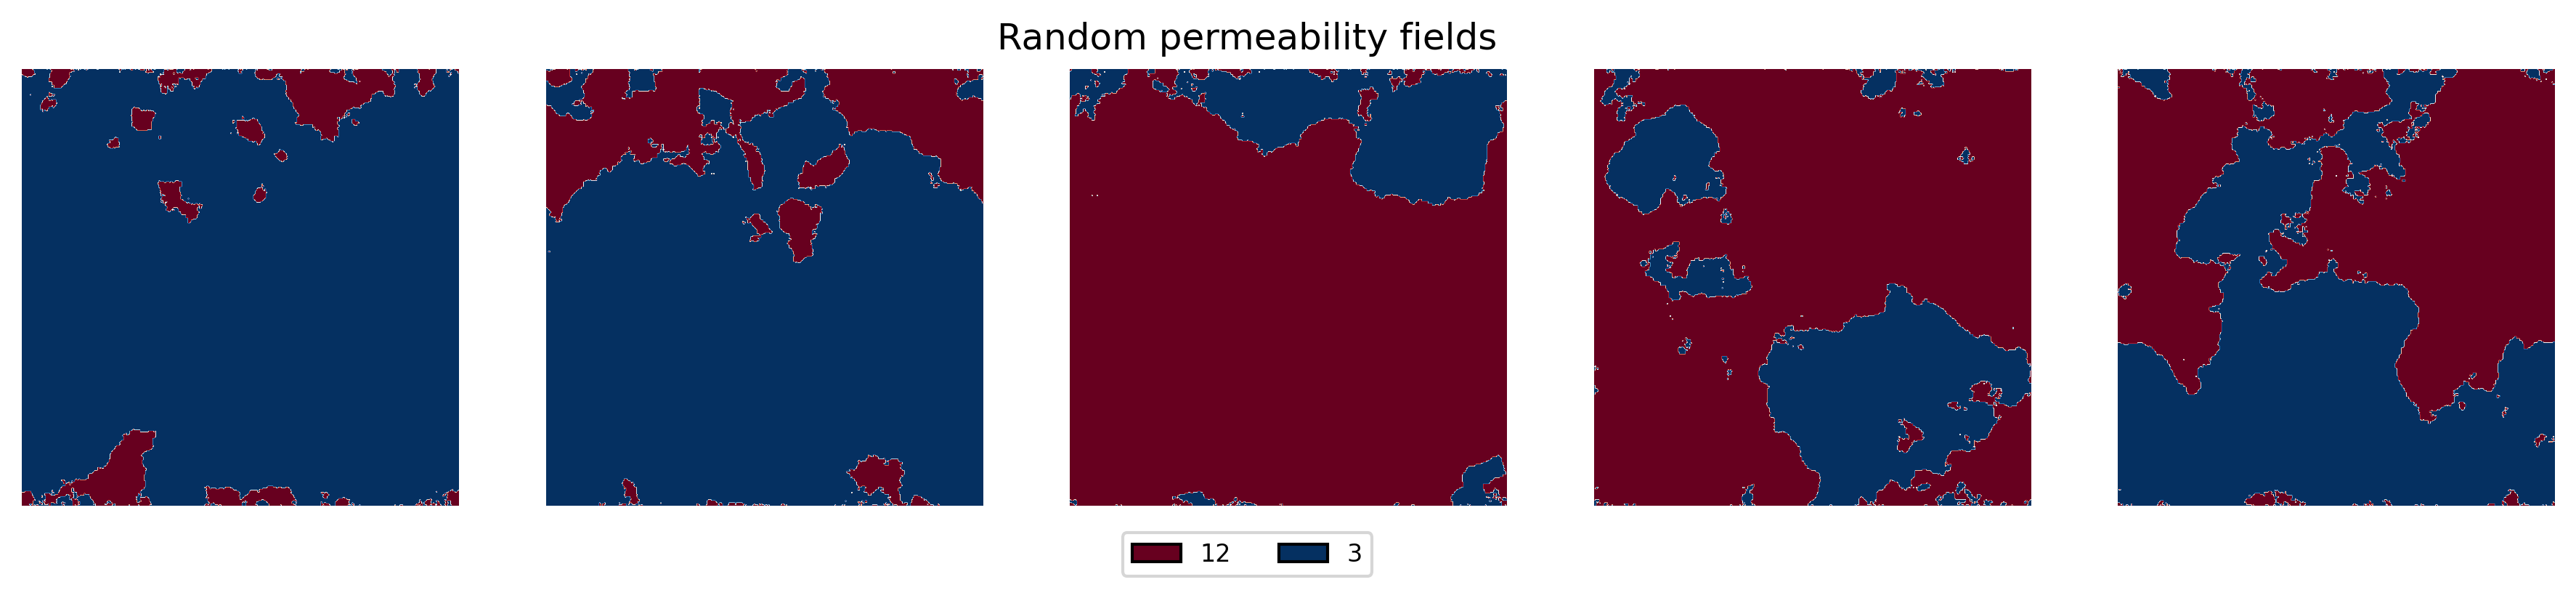

In [8]:
from matplotlib.patches import Patch

random_fields_binarized = [phi(random_field.reshape(n_points, n_points)) for random_field in random_fields]
# Visualize the generated random field

fig, axs = plt.subplots(1, 5, dpi=300, figsize=(15, 4))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(random_fields_binarized[i], extent=[0, grid_size, 0, grid_size], cmap='RdBu_r', vmin=3, vmax=12)
    ax.axis('off')

plt.suptitle(r'Random permeability fields', y = .8)
# Create a custom legend

legend_elements = [Patch(facecolor=plt.colormaps.get_cmap("RdBu")(0), edgecolor='k', label='12'),
                   Patch(facecolor=plt.colormaps.get_cmap("RdBu_r")(0), edgecolor='k', label='3')]

fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.15))
plt.savefig('figures/random_fields.pdf', dpi=300)
plt.show()


In [6]:
def f(x):
    if x.ndim == 1:
        return 1.0
    elif x.ndim == 2:
        return np.ones(x.shape[0])

u_sol = []
for a in random_fields_binarized:
    Nx, Ny = a.shape[0] - 2, a.shape[1] - 2

    idx_inject = (50, 50)
    idx_eject = (Nx - 50, Ny - 50)

    u = solve_Darcy_PDE(Nx, Ny , a, f)
    u_sol.append(u)


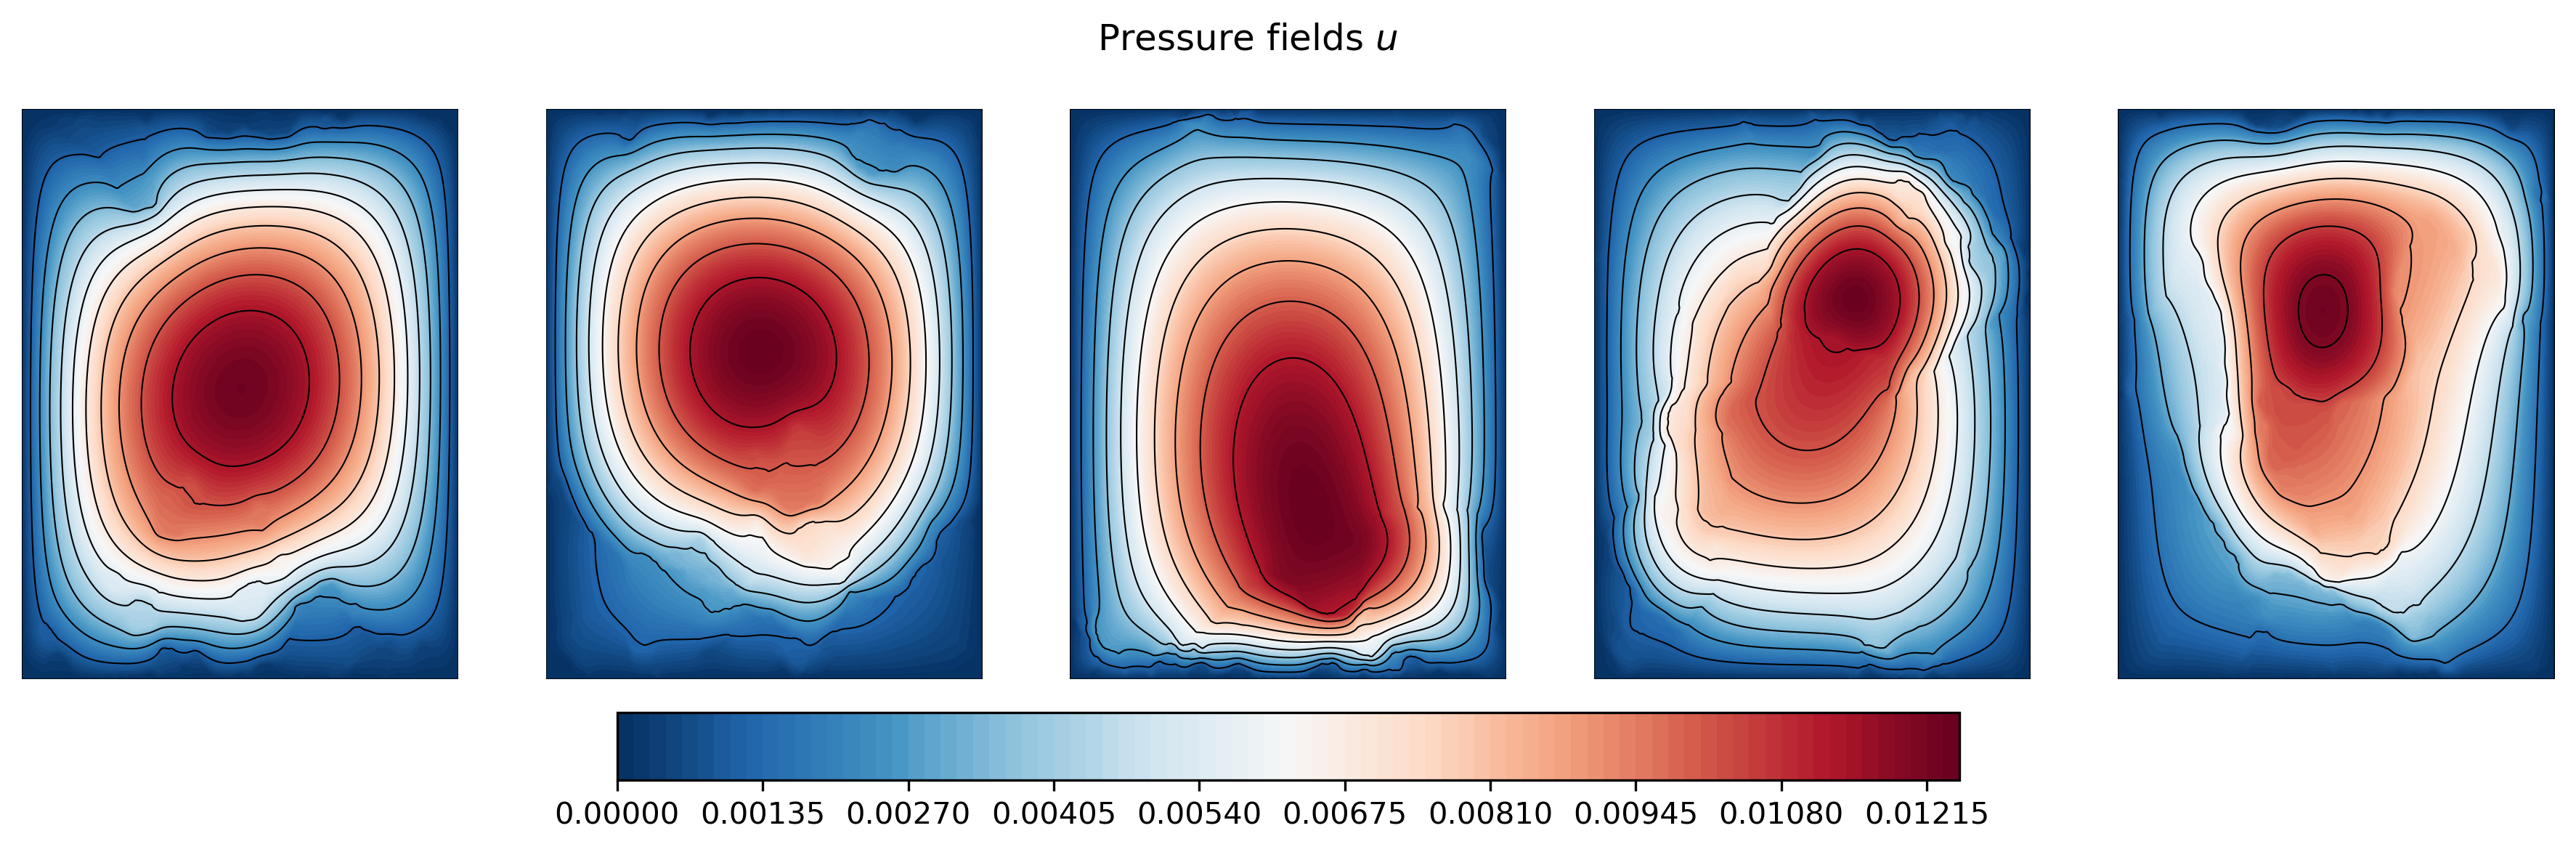

In [7]:
fig, axs = plt.subplots(1, 5, dpi=300, figsize=(15, 4))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.contour(u_sol[i], levels = 10, colors='k', linewidths=0.5)
    contf = ax.contourf(u_sol[i], cmap='RdBu_r', levels = 100)
    ax.axis('off')


cbar = plt.colorbar(contf, ax=axs, orientation='horizontal', fraction=0.1, pad=0.05)

plt.suptitle(r'Pressure fields $u$')
plt.savefig('figures/pressure_fields.pdf', dpi=300)
plt.show()
